# Homework 1

## Instructions

First, ensure you have cloned the [course repository](https://github.com/lydiaYchen/DDL24Spring).

Then, open the [interactive notebook version](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/hw-hfl.ipynb) of this homework from your local clone.

Further, complete the homework by filling in the code and answers and save your changes.

Finally, upload the notebook to the assignment in ILIAS.

## Note

When not otherwise specified, use the following parameter values in experiment runs:
- `nr_clients` (N): 100
- `lr`: 0.01
- `client_fraction`(C): 0.1
- `nr_local_epochs` (E): 1
- `batch_size` (B): 100
- `nr_rounds`: 10
- `iid`: True

For all exercises, pass `seed = 10` to calls for splitting data, server initialization, or plotting.

In [1]:
import pandas as pd
import seaborn as sns
from base import *
from IPython.display import display
import matplotlib.pyplot as plt
import torch

n = 100 # nr_clients
lr = 0.01 # lr
c = 0.1 # client_fraction
e = 1 # nr_local_epochs
b = 100 # batch_size
nr_rounds = 10 # nr_rounds
iid = True
seed = 10

cuda


## Exercise 1 - FedSGD with weights (3 points)

### Question

_(2 points)_ Implement a version of FedSGD that uses weights in its updates, like FedAvg, instead of the gradients from the version of the tutorials. The two FedSGD versions should have the same test accuracy after each round (with a tolerance of at most 0.02%). To show this, compare their output for the following two scenarios over *5 rounds*:
- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5`
- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

*Tip:* You can use the existing FedAvg implementation to minimize the amount of code writing required.

_(1 point)_ Explain in which cases (about the different parameters for decentralized learning) the two are equivalent.

Answer:\
When using FedAvg, if batchsize is set to the length of subset, then there will be only one forward propagation, because all the data of subset is computed by this propagation; at the same time, setting epoch to 1 ensures that there will be only one round of computation on the client. \
That is to say, when batchsize = len(subset), epoch = 1, the weights on each client will be updated only once, and will be handed over to Server, which weights the weights and returns them to the client, which is the same as FedSGD. Since updating the weights is just an addition operation, the process is the same on the client or the server in this case.

### Answer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

cuda
True


Implement Infinite Batch version from FedAvgServer

In [6]:
class FedAvgServer_InfBatch(FedAvgServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list[Subset], client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.name = "FedAvgInfB"
        self.batch_size = -1
        self.clients = [WeightClient(subset, lr, len(subset), nr_local_epochs) for subset in client_subsets]

In [29]:
# define ablation function with initial values
def Ablation_Experiment(lr = 0.01, client_subsets = split(100, True, seed = 10), client_fraction = 0.1, nr_rounds = 10, avg_batchsize = 100, nr_local_epochs = 1, FedSgd_flag = True, FedAvg_flag = True, FedAvgInfBatch_flag = False, display_flag = True):

    pd_idf = []

    if FedSgd_flag:
        fedsgd_server = FedSgdGradientServer(lr, client_subsets, client_fraction, seed)
        fedsgd_results = fedsgd_server.run(nr_rounds)
        fedsgd_df = fedsgd_results.as_df()
        if display_flag: display(fedsgd_df)
        pd_idf.append(fedsgd_df)
    if FedAvg_flag:
        fedavg_server = FedAvgServer(lr, avg_batchsize, client_subsets, client_fraction, nr_local_epochs, seed)
        fedavg_results = fedavg_server.run(nr_rounds)    
        fedavg_df = fedavg_results.as_df()
        if display_flag: display(fedavg_df)
        pd_idf.append(fedavg_df)
    if FedAvgInfBatch_flag:
        fedavginf_server = FedAvgServer_InfBatch(lr, avg_batchsize, client_subsets, client_fraction, nr_local_epochs, seed)
        fedavginf_results = fedavginf_server.run(nr_rounds)    
        fedavginf_df = fedavginf_results.as_df()
        if display_flag: display(fedavginf_df)
        pd_idf.append(fedavginf_df)

    plt.figure(figsize=(5, 3))
    df = pd.concat(pd_idf, ignore_index=True)
    ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=0)
    _ = ax.set_xticks(df["Round"].unique())
    plt.show()

- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5 over 5 round`

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.5,∞,1,0.01,10,0.3,100,8.84
1,2,FedSGDGradient,100,0.5,∞,1,0.01,10,0.4,200,13.32
2,3,FedSGDGradient,100,0.5,∞,1,0.01,10,0.5,300,18.44
3,4,FedSGDGradient,100,0.5,∞,1,0.01,10,0.6,400,23.14
4,5,FedSGDGradient,100,0.5,∞,1,0.01,10,0.7,500,27.58


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvgInfB,100,0.5,∞,1,0.01,10,0.1,100,8.84
1,2,FedAvgInfB,100,0.5,∞,1,0.01,10,0.2,200,13.32
2,3,FedAvgInfB,100,0.5,∞,1,0.01,10,0.2,300,18.44
3,4,FedAvgInfB,100,0.5,∞,1,0.01,10,0.3,400,23.14
4,5,FedAvgInfB,100,0.5,∞,1,0.01,10,0.4,500,27.58


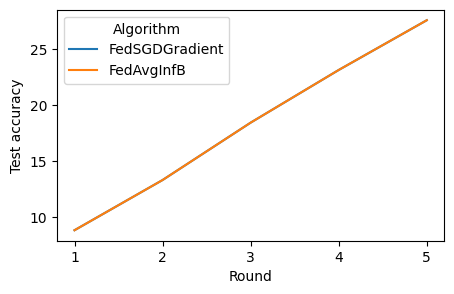

In [8]:
Ablation_Experiment(lr = 0.01, client_subsets = split(100, True, seed), client_fraction = 0.5, nr_rounds = 5, FedAvg_flag = False, FedAvgInfBatch_flag = True)

- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,50,0.2,∞,1,0.1,10,0.5,20,16.29
1,2,FedSGDGradient,50,0.2,∞,1,0.1,10,0.6,40,24.77
2,3,FedSGDGradient,50,0.2,∞,1,0.1,10,0.7,60,13.11
3,4,FedSGDGradient,50,0.2,∞,1,0.1,10,0.8,80,20.75
4,5,FedSGDGradient,50,0.2,∞,1,0.1,10,0.9,100,38.44


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvgInfB,50,0.2,∞,1,0.1,10,0.1,20,16.29
1,2,FedAvgInfB,50,0.2,∞,1,0.1,10,0.2,40,24.77
2,3,FedAvgInfB,50,0.2,∞,1,0.1,10,0.3,60,13.11
3,4,FedAvgInfB,50,0.2,∞,1,0.1,10,0.4,80,20.76
4,5,FedAvgInfB,50,0.2,∞,1,0.1,10,0.6,100,38.43


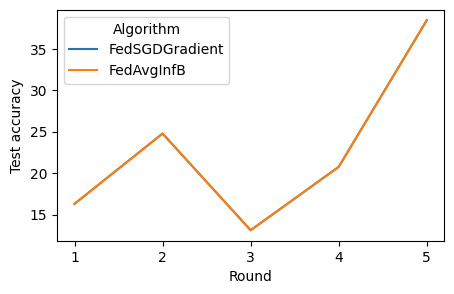

In [9]:
Ablation_Experiment(lr = 0.1, client_subsets = split(50, False, seed), client_fraction = 0.2, nr_rounds = 5, FedAvg_flag = False, FedAvgInfBatch_flag = True)

## Exercise 2 - Client number & fraction (4 points)

### Question

_(2 points)_ Run the necessary experiments to fill in the following table showing the final message count and test accuracy of FedSGD and FedAvg for different total client numbers:

| Algorithm | N   | C   | Message count | Test accuracy |
| --------- | --- | --- | ------------- | ------------- |
| FedSGD    | 10  | 0.1 |              20 |              59.55 |
| FedAvg    | 10  | 0.1 |              20 |              97.84 |
| FedSGD    | 50  | 0.1 |              100 |              66.69 |
| FedAvg    | 50  | 0.1 |              100 |              95.10 |
| FedSGD    | 100 | 0.1 |              200 |              74.33 |
| FedAvg    | 100 | 0.1 |              200 |              91.81 |

Is the relationship between the metrics and client numbers monotonous?

Answer:\
Yes, they are monotonous according to this table.\
For FedSGD: It can be seen that the accuracy gets larger as the total client numbers get larger, around 8%-9% at a time. I think this is because the Client in FedSGD is only forward propagated once per epoch, and the weight is updated very slowly, and is still far from being fit. And the increase in total client numbers allows it to learn and converge faster for the same number of epochs;
For FedAvg: you can see that accuracy gets progressively smaller as total client numbers get larger, around 2% at a time. I think this is because there are more clients and each client gets a smaller dataset. Multiple rounds of training with mini-batch on a small dataset may lead to overfitting against this subset, which in turn performs poorly on the whole.

_(2 points)_ Run the experiments to fill in the table when varying the fraction of clients used in every round:

| Algorithm | N   | C    | Message count | Test accuracy |
| --------- | --- | ---- | ------------- | ------------- |
| FedSGD    | 100 | 0.01 |              200 |              43.20 |
| FedAvg    | 100 | 0.01 |              200 |              82.06 |
| FedSGD    | 100 | 0.1  |              200 |              74.33 |
| FedAvg    | 100 | 0.1  |              200 |              91.81 |
| FedSGD    | 100 | 0.2  |              200 |              61.77 |
| FedAvg    | 100 | 0.2  |              200 |              94.16 |

How does the observed pattern differ?

Answer:\
For FedSGD: accuracy went up and then down as the learning rate went up. I think c = 0.2 might be causing it to overfit (just 10 rounds?) ;\
For FedAvg: accuracy kept going up as the learning rate went up. I think this is because the sum of the gradients computed by each client is smaller because the dataset is smaller. So a larger learning rate like 0.2 might make it learn faster (although I don't think increasing the learning rate all the time makes accuracy better).

### Answer

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,10,0.1,∞,1,0.01,10,0.5,2,9.29
1,2,FedSGDGradient,10,0.1,∞,1,0.01,10,1.0,4,13.80
2,3,FedSGDGradient,10,0.1,∞,1,0.01,10,1.4,6,18.67
3,4,FedSGDGradient,10,0.1,∞,1,0.01,10,1.9,8,23.10
4,5,FedSGDGradient,10,0.1,∞,1,0.01,10,2.3,10,27.12
5,6,FedSGDGradient,10,0.1,∞,1,0.01,10,2.8,12,30.67
6,7,FedSGDGradient,10,0.1,∞,1,0.01,10,3.2,14,35.25
7,8,FedSGDGradient,10,0.1,∞,1,0.01,10,3.7,16,38.82
8,9,FedSGDGradient,10,0.1,∞,1,0.01,10,4.1,18,41.57
9,10,FedSGDGradient,10,0.1,∞,1,0.01,10,4.6,20,42.88


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,10,0.1,100,1,0.01,10,0.5,2,75.76
1,2,FedAvg,10,0.1,100,1,0.01,10,0.9,4,87.42
2,3,FedAvg,10,0.1,100,1,0.01,10,1.4,6,89.13
3,4,FedAvg,10,0.1,100,1,0.01,10,1.9,8,90.07
4,5,FedAvg,10,0.1,100,1,0.01,10,2.4,10,91.14
5,6,FedAvg,10,0.1,100,1,0.01,10,2.9,12,91.69
6,7,FedAvg,10,0.1,100,1,0.01,10,3.4,14,91.84
7,8,FedAvg,10,0.1,100,1,0.01,10,3.9,16,92.92
8,9,FedAvg,10,0.1,100,1,0.01,10,4.4,18,92.75
9,10,FedAvg,10,0.1,100,1,0.01,10,4.9,20,93.36


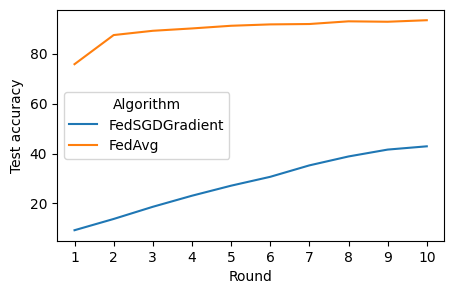

In [16]:
Ablation_Experiment(client_fraction = 0.1, client_subsets = split(10, iid, seed))

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,50,0.1,∞,1,0.01,10,0.1,10,9.45
1,2,FedSGDGradient,50,0.1,∞,1,0.01,10,0.2,20,14.33
2,3,FedSGDGradient,50,0.1,∞,1,0.01,10,0.3,30,18.81
3,4,FedSGDGradient,50,0.1,∞,1,0.01,10,0.4,40,22.98
4,5,FedSGDGradient,50,0.1,∞,1,0.01,10,0.5,50,27.43
5,6,FedSGDGradient,50,0.1,∞,1,0.01,10,0.6,60,31.07
6,7,FedSGDGradient,50,0.1,∞,1,0.01,10,0.7,70,35.39
7,8,FedSGDGradient,50,0.1,∞,1,0.01,10,0.8,80,38.70
8,9,FedSGDGradient,50,0.1,∞,1,0.01,10,0.9,90,41.70
9,10,FedSGDGradient,50,0.1,∞,1,0.01,10,1.0,100,43.95


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,50,0.1,100,1,0.01,10,0.1,10,48.48
1,2,FedAvg,50,0.1,100,1,0.01,10,0.2,20,65.44
2,3,FedAvg,50,0.1,100,1,0.01,10,0.3,30,66.23
3,4,FedAvg,50,0.1,100,1,0.01,10,0.4,40,77.26
4,5,FedAvg,50,0.1,100,1,0.01,10,0.5,50,81.72
5,6,FedAvg,50,0.1,100,1,0.01,10,0.6,60,83.40
6,7,FedAvg,50,0.1,100,1,0.01,10,0.7,70,85.81
7,8,FedAvg,50,0.1,100,1,0.01,10,0.8,80,86.44
8,9,FedAvg,50,0.1,100,1,0.01,10,0.9,90,87.54
9,10,FedAvg,50,0.1,100,1,0.01,10,1.1,100,87.55


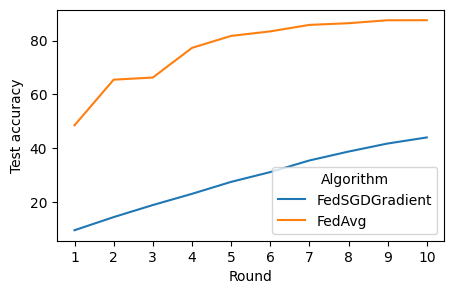

In [17]:
Ablation_Experiment(client_fraction = 0.1, client_subsets = split(50, iid, seed))

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.01,10,0.1,20,9.03
1,2,FedSGDGradient,100,0.1,∞,1,0.01,10,0.2,40,13.54
2,3,FedSGDGradient,100,0.1,∞,1,0.01,10,0.2,60,18.39
3,4,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,80,22.87
4,5,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,100,27.09
5,6,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,120,31.08
6,7,FedSGDGradient,100,0.1,∞,1,0.01,10,0.5,140,35.29
7,8,FedSGDGradient,100,0.1,∞,1,0.01,10,0.5,160,38.75
8,9,FedSGDGradient,100,0.1,∞,1,0.01,10,0.6,180,41.02
9,10,FedSGDGradient,100,0.1,∞,1,0.01,10,0.6,200,43.20


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,1,0.01,10,0.1,20,30.02
1,2,FedAvg,100,0.1,100,1,0.01,10,0.1,40,46.55
2,3,FedAvg,100,0.1,100,1,0.01,10,0.2,60,58.44
3,4,FedAvg,100,0.1,100,1,0.01,10,0.2,80,64.85
4,5,FedAvg,100,0.1,100,1,0.01,10,0.3,100,70.98
5,6,FedAvg,100,0.1,100,1,0.01,10,0.4,120,73.93
6,7,FedAvg,100,0.1,100,1,0.01,10,0.4,140,76.05
7,8,FedAvg,100,0.1,100,1,0.01,10,0.5,160,78.07
8,9,FedAvg,100,0.1,100,1,0.01,10,0.5,180,79.36
9,10,FedAvg,100,0.1,100,1,0.01,10,0.6,200,82.06


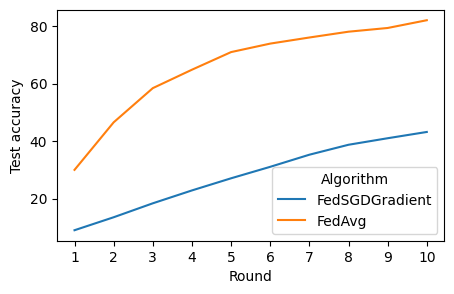

In [18]:
Ablation_Experiment(client_fraction = 0.1, client_subsets = split(100, iid, seed))

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.01,∞,1,0.01,10,0.1,2,9.95
1,2,FedSGDGradient,100,0.01,∞,1,0.01,10,0.1,4,15.68
2,3,FedSGDGradient,100,0.01,∞,1,0.01,10,0.2,6,20.83
3,4,FedSGDGradient,100,0.01,∞,1,0.01,10,0.2,8,24.61
4,5,FedSGDGradient,100,0.01,∞,1,0.01,10,0.3,10,28.19
5,6,FedSGDGradient,100,0.01,∞,1,0.01,10,0.3,12,32.58
6,7,FedSGDGradient,100,0.01,∞,1,0.01,10,0.3,14,35.44
7,8,FedSGDGradient,100,0.01,∞,1,0.01,10,0.4,16,39.22
8,9,FedSGDGradient,100,0.01,∞,1,0.01,10,0.4,18,41.59
9,10,FedSGDGradient,100,0.01,∞,1,0.01,10,0.5,20,41.54


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.01,100,1,0.01,10,0.1,2,29.52
1,2,FedAvg,100,0.01,100,1,0.01,10,0.1,4,38.55
2,3,FedAvg,100,0.01,100,1,0.01,10,0.2,6,46.15
3,4,FedAvg,100,0.01,100,1,0.01,10,0.2,8,55.69
4,5,FedAvg,100,0.01,100,1,0.01,10,0.3,10,64.20
5,6,FedAvg,100,0.01,100,1,0.01,10,0.3,12,69.67
6,7,FedAvg,100,0.01,100,1,0.01,10,0.4,14,62.49
7,8,FedAvg,100,0.01,100,1,0.01,10,0.4,16,72.23
8,9,FedAvg,100,0.01,100,1,0.01,10,0.5,18,71.85
9,10,FedAvg,100,0.01,100,1,0.01,10,0.5,20,75.15


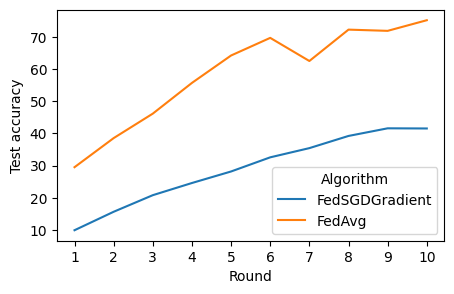

In [19]:
Ablation_Experiment(client_fraction = 0.01, client_subsets = split(100, iid, seed))

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.01,10,0.1,20,9.03
1,2,FedSGDGradient,100,0.1,∞,1,0.01,10,0.1,40,13.54
2,3,FedSGDGradient,100,0.1,∞,1,0.01,10,0.2,60,18.39
3,4,FedSGDGradient,100,0.1,∞,1,0.01,10,0.2,80,22.87
4,5,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,100,27.09
5,6,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,120,31.08
6,7,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,140,35.29
7,8,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,160,38.75
8,9,FedSGDGradient,100,0.1,∞,1,0.01,10,0.5,180,41.02
9,10,FedSGDGradient,100,0.1,∞,1,0.01,10,0.6,200,43.20


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,1,0.01,10,0.1,20,30.02
1,2,FedAvg,100,0.1,100,1,0.01,10,0.1,40,46.55
2,3,FedAvg,100,0.1,100,1,0.01,10,0.2,60,58.44
3,4,FedAvg,100,0.1,100,1,0.01,10,0.2,80,64.85
4,5,FedAvg,100,0.1,100,1,0.01,10,0.3,100,70.98
5,6,FedAvg,100,0.1,100,1,0.01,10,0.3,120,73.93
6,7,FedAvg,100,0.1,100,1,0.01,10,0.4,140,76.05
7,8,FedAvg,100,0.1,100,1,0.01,10,0.5,160,78.07
8,9,FedAvg,100,0.1,100,1,0.01,10,0.5,180,79.36
9,10,FedAvg,100,0.1,100,1,0.01,10,0.6,200,82.06


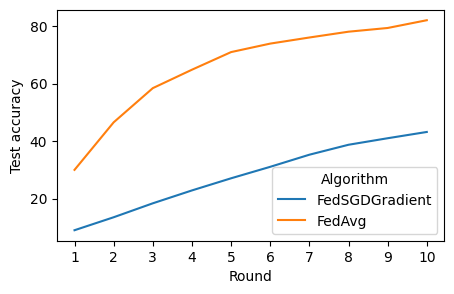

In [20]:
Ablation_Experiment(client_fraction = 0.1, client_subsets = split(100, iid, seed))

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.2,∞,1,0.01,10,0.1,40,9.01
1,2,FedSGDGradient,100,0.2,∞,1,0.01,10,0.1,80,13.72
2,3,FedSGDGradient,100,0.2,∞,1,0.01,10,0.2,120,18.51
3,4,FedSGDGradient,100,0.2,∞,1,0.01,10,0.2,160,23.22
4,5,FedSGDGradient,100,0.2,∞,1,0.01,10,0.3,200,27.57
5,6,FedSGDGradient,100,0.2,∞,1,0.01,10,0.4,240,32.01
6,7,FedSGDGradient,100,0.2,∞,1,0.01,10,0.4,280,35.71
7,8,FedSGDGradient,100,0.2,∞,1,0.01,10,0.5,320,38.91
8,9,FedSGDGradient,100,0.2,∞,1,0.01,10,0.5,360,40.76
9,10,FedSGDGradient,100,0.2,∞,1,0.01,10,0.6,400,42.62


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.2,100,1,0.01,10,0.1,40,31.28
1,2,FedAvg,100,0.2,100,1,0.01,10,0.1,80,45.05
2,3,FedAvg,100,0.2,100,1,0.01,10,0.2,120,55.35
3,4,FedAvg,100,0.2,100,1,0.01,10,0.2,160,61.45
4,5,FedAvg,100,0.2,100,1,0.01,10,0.3,200,65.66
5,6,FedAvg,100,0.2,100,1,0.01,10,0.4,240,71.60
6,7,FedAvg,100,0.2,100,1,0.01,10,0.4,280,73.67
7,8,FedAvg,100,0.2,100,1,0.01,10,0.5,320,74.65
8,9,FedAvg,100,0.2,100,1,0.01,10,0.5,360,79.95
9,10,FedAvg,100,0.2,100,1,0.01,10,0.6,400,81.55


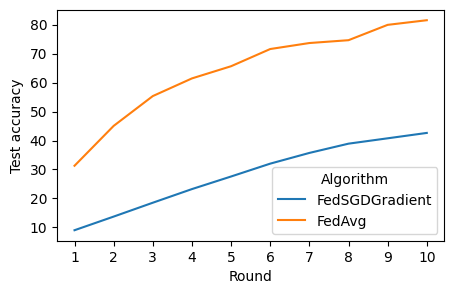

In [21]:
Ablation_Experiment(client_fraction = 0.2, client_subsets = split(100, iid, seed))

## Exercise 3 - Batch size & learning rate (4 points)

### Question

_(2 points)_ Complete the following table with the last-round wall time and test accuracy of FedAvg under different batch sizes:

| Algorithm | B   | η    | Wall time | Test accuracy |
| --------- | --- | ---- | --------- | ------------- |
| FedAvg    | 10  | 0.01 |          3.1 |              92.18 |
| FedAvg    | 100 | 0.01 |          1.6 |              81.78 |
| FedAvg    | 500 | 0.01 |          1.7 |              59.63 |

What is the trade-off for larger batch sizes?

*Note:* The exact measured time will differ from run to run, even on the same machine, but the trends should remain the same. Furthermore, the effect of batch size on wall time is less pronounced and, depending on the exact hardware is sometimes minimal when running on CPU instead of GPU.

_(2 points)_ Add the corresponding values for varying learning rates, also for FedSGD, in the table below:

| Algorithm | B   | η     | Wall time | Test accuracy |
| --------- | --- | ----- | --------- | ------------- |
| FedSGD    | ∞   | 0.001 |          1.0 |              7.39 |
| FedAvg    | 100 | 0.001 |          1.9 |              31.72 |
| FedSGD    | ∞   | 0.01  |          1.0 |              27.34 |
| FedAvg    | 100 | 0.01  |          1.6 |              81.78 |
| FedSGD    | ∞   | 1.0   |           |               |
| FedAvg    | 100 | 1.0   |           |               |

Does the learning rate influence the wall time? For accuracy, how does it change the value obtained within the set number of rounds? Can it impact the model's convergence?

### Answer

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,10,1,0.01,10,0.1,20,69.38
1,2,FedAvg,100,0.1,10,1,0.01,10,0.3,40,84.99
2,3,FedAvg,100,0.1,10,1,0.01,10,0.4,60,86.83
3,4,FedAvg,100,0.1,10,1,0.01,10,0.6,80,88.96
4,5,FedAvg,100,0.1,10,1,0.01,10,0.7,100,90.11
5,6,FedAvg,100,0.1,10,1,0.01,10,0.9,120,90.17
6,7,FedAvg,100,0.1,10,1,0.01,10,1.0,140,90.77
7,8,FedAvg,100,0.1,10,1,0.01,10,1.1,160,91.58
8,9,FedAvg,100,0.1,10,1,0.01,10,1.3,180,91.99
9,10,FedAvg,100,0.1,10,1,0.01,10,1.4,200,92.29


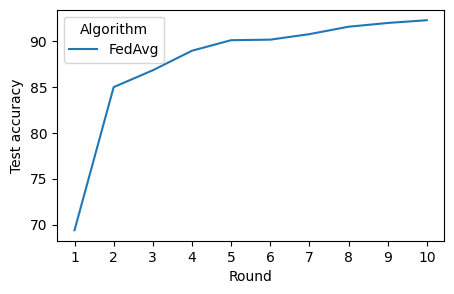

In [22]:
Ablation_Experiment(avg_batchsize = 10, lr = 0.01, FedSgd_flag = False)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,1,0.01,10,0.1,20,30.02
1,2,FedAvg,100,0.1,100,1,0.01,10,0.1,40,46.55
2,3,FedAvg,100,0.1,100,1,0.01,10,0.2,60,58.44
3,4,FedAvg,100,0.1,100,1,0.01,10,0.2,80,64.85
4,5,FedAvg,100,0.1,100,1,0.01,10,0.3,100,70.98
5,6,FedAvg,100,0.1,100,1,0.01,10,0.3,120,73.93
6,7,FedAvg,100,0.1,100,1,0.01,10,0.4,140,76.05
7,8,FedAvg,100,0.1,100,1,0.01,10,0.5,160,78.07
8,9,FedAvg,100,0.1,100,1,0.01,10,0.5,180,79.36
9,10,FedAvg,100,0.1,100,1,0.01,10,0.6,200,82.06


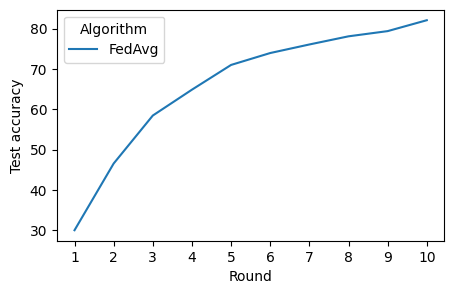

In [23]:
Ablation_Experiment(avg_batchsize = 100, lr = 0.01, FedSgd_flag = False)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,500,1,0.01,10,0.1,20,14.64
1,2,FedAvg,100,0.1,500,1,0.01,10,0.1,40,24.56
2,3,FedAvg,100,0.1,500,1,0.01,10,0.2,60,32.15
3,4,FedAvg,100,0.1,500,1,0.01,10,0.2,80,39.37
4,5,FedAvg,100,0.1,500,1,0.01,10,0.3,100,44.91
5,6,FedAvg,100,0.1,500,1,0.01,10,0.3,120,47.41
6,7,FedAvg,100,0.1,500,1,0.01,10,0.4,140,50.06
7,8,FedAvg,100,0.1,500,1,0.01,10,0.4,160,54.10
8,9,FedAvg,100,0.1,500,1,0.01,10,0.5,180,54.93
9,10,FedAvg,100,0.1,500,1,0.01,10,0.5,200,59.45


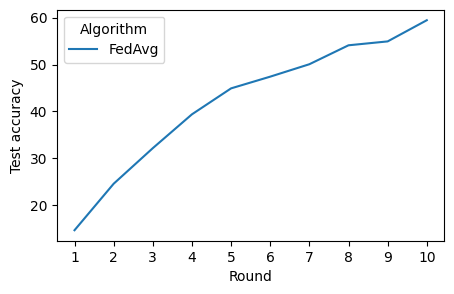

In [24]:
Ablation_Experiment(avg_batchsize = 500, lr = 0.01, FedSgd_flag = False)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.001,10,0.1,20,6.44
1,2,FedSGDGradient,100,0.1,∞,1,0.001,10,0.1,40,6.58
2,3,FedSGDGradient,100,0.1,∞,1,0.001,10,0.2,60,6.76
3,4,FedSGDGradient,100,0.1,∞,1,0.001,10,0.2,80,7.07
4,5,FedSGDGradient,100,0.1,∞,1,0.001,10,0.3,100,7.35
5,6,FedSGDGradient,100,0.1,∞,1,0.001,10,0.3,120,7.62
6,7,FedSGDGradient,100,0.1,∞,1,0.001,10,0.4,140,7.85
7,8,FedSGDGradient,100,0.1,∞,1,0.001,10,0.4,160,8.18
8,9,FedSGDGradient,100,0.1,∞,1,0.001,10,0.5,180,8.46
9,10,FedSGDGradient,100,0.1,∞,1,0.001,10,0.6,200,8.83


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,1,0.001,10,0.1,20,7.62
1,2,FedAvg,100,0.1,100,1,0.001,10,0.1,40,9.72
2,3,FedAvg,100,0.1,100,1,0.001,10,0.2,60,12.23
3,4,FedAvg,100,0.1,100,1,0.001,10,0.2,80,15.18
4,5,FedAvg,100,0.1,100,1,0.001,10,0.3,100,18.53
5,6,FedAvg,100,0.1,100,1,0.001,10,0.3,120,21.46
6,7,FedAvg,100,0.1,100,1,0.001,10,0.4,140,23.98
7,8,FedAvg,100,0.1,100,1,0.001,10,0.5,160,26.61
8,9,FedAvg,100,0.1,100,1,0.001,10,0.5,180,29.05
9,10,FedAvg,100,0.1,100,1,0.001,10,0.6,200,31.90


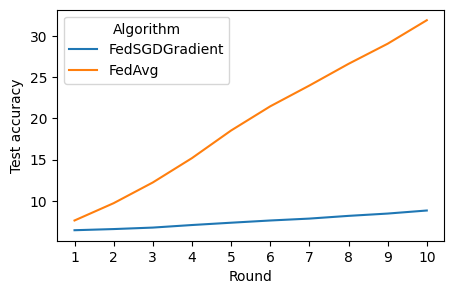

In [25]:
Ablation_Experiment(avg_batchsize = 100, lr = 0.001)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.01,10,0.1,20,9.03
1,2,FedSGDGradient,100,0.1,∞,1,0.01,10,0.1,40,13.54
2,3,FedSGDGradient,100,0.1,∞,1,0.01,10,0.2,60,18.39
3,4,FedSGDGradient,100,0.1,∞,1,0.01,10,0.2,80,22.87
4,5,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,100,27.09
5,6,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,120,31.08
6,7,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,140,35.29
7,8,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,160,38.75
8,9,FedSGDGradient,100,0.1,∞,1,0.01,10,0.5,180,41.02
9,10,FedSGDGradient,100,0.1,∞,1,0.01,10,0.6,200,43.20


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,1,0.01,10,0.1,20,30.02
1,2,FedAvg,100,0.1,100,1,0.01,10,0.1,40,46.55
2,3,FedAvg,100,0.1,100,1,0.01,10,0.2,60,58.44
3,4,FedAvg,100,0.1,100,1,0.01,10,0.2,80,64.85
4,5,FedAvg,100,0.1,100,1,0.01,10,0.3,100,70.98
5,6,FedAvg,100,0.1,100,1,0.01,10,0.3,120,73.93
6,7,FedAvg,100,0.1,100,1,0.01,10,0.4,140,76.05
7,8,FedAvg,100,0.1,100,1,0.01,10,0.5,160,78.07
8,9,FedAvg,100,0.1,100,1,0.01,10,0.5,180,79.36
9,10,FedAvg,100,0.1,100,1,0.01,10,0.6,200,82.06


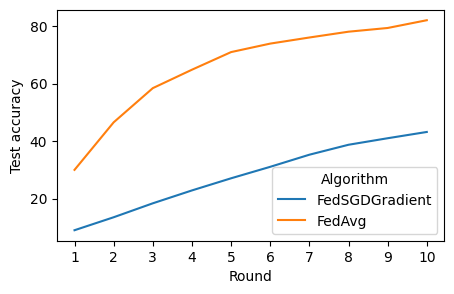

In [26]:
Ablation_Experiment(avg_batchsize = 100, lr = 0.01)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,1.0,10,0.1,20,36.30
1,2,FedSGDGradient,100,0.1,∞,1,1.0,10,0.1,40,39.98
2,3,FedSGDGradient,100,0.1,∞,1,1.0,10,0.2,60,9.74
3,4,FedSGDGradient,100,0.1,∞,1,1.0,10,0.2,80,11.45
4,5,FedSGDGradient,100,0.1,∞,1,1.0,10,0.3,100,11.35
5,6,FedSGDGradient,100,0.1,∞,1,1.0,10,0.3,120,10.09
6,7,FedSGDGradient,100,0.1,∞,1,1.0,10,0.4,140,11.35
7,8,FedSGDGradient,100,0.1,∞,1,1.0,10,0.4,160,11.35
8,9,FedSGDGradient,100,0.1,∞,1,1.0,10,0.5,180,11.35
9,10,FedSGDGradient,100,0.1,∞,1,1.0,10,0.5,200,11.35


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,1,1.0,10,0.1,20,11.48
1,2,FedAvg,100,0.1,100,1,1.0,10,0.1,40,25.14
2,3,FedAvg,100,0.1,100,1,1.0,10,0.2,60,11.35
3,4,FedAvg,100,0.1,100,1,1.0,10,0.2,80,27.52
4,5,FedAvg,100,0.1,100,1,1.0,10,0.3,100,23.66
5,6,FedAvg,100,0.1,100,1,1.0,10,0.3,120,16.85
6,7,FedAvg,100,0.1,100,1,1.0,10,0.4,140,24.82
7,8,FedAvg,100,0.1,100,1,1.0,10,0.5,160,19.89
8,9,FedAvg,100,0.1,100,1,1.0,10,0.5,180,23.08
9,10,FedAvg,100,0.1,100,1,1.0,10,0.6,200,9.80


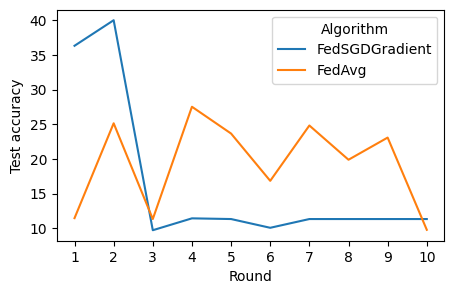

In [27]:
Ablation_Experiment(avg_batchsize = 100, lr = 1.0)

## Exercise 4 - Local epoch count & (non-)IID data (5 points)

### Question

_(1 point)_ Create a line plot of the accuracy after each round for the following algorithm variants:

- FedSGD
- FedAvg (E=1)
- FedAvg (E=2)
- FedAvg (E=4)

How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?

_(2 points)_ Make one line plot of FedSGD and FedAvg under an IID and non-IID split for 15 rounds (leaving all other parameter values as they previously mentioned default). How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?

_(2 points)_ Make another plot for only non-IID splits, including the FedSGD and FedAvg configs from before, and add a version for each with a learning rate of 0.001 and client fraction of 0.5. How does the stability of the new variants compare to the old ones? Why do the changes in parameters have the observed effect?

### Answer

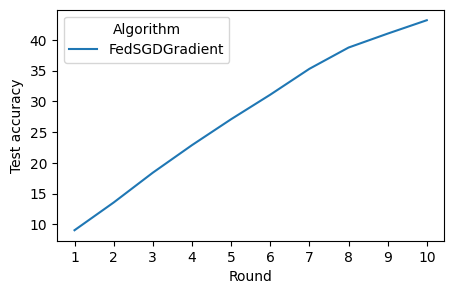

In [30]:
Ablation_Experiment(FedAvg_flag = False, display_flag = False)

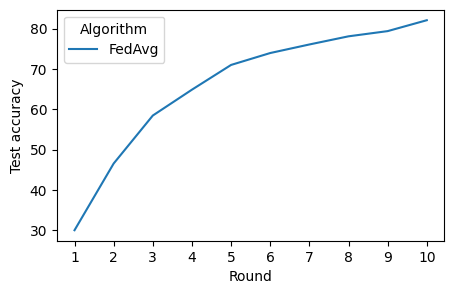

In [31]:
Ablation_Experiment(nr_local_epochs = 1, FedSgd_flag = False, display_flag = False)

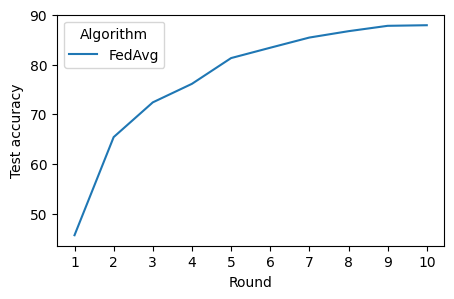

In [32]:
Ablation_Experiment(nr_local_epochs = 2, FedSgd_flag = False, display_flag = False)

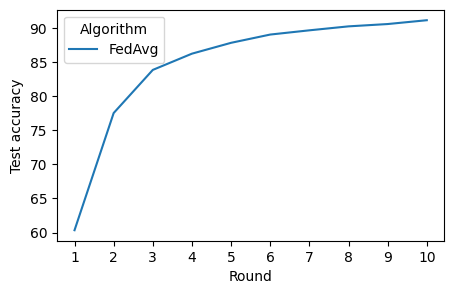

In [33]:
Ablation_Experiment(nr_local_epochs = 4, FedSgd_flag = False, display_flag = False)

TODO

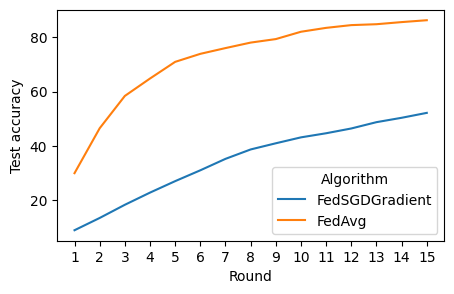

In [38]:
Ablation_Experiment(client_subsets = split(100, iid = True, seed = 10), nr_rounds = 15, display_flag = False)

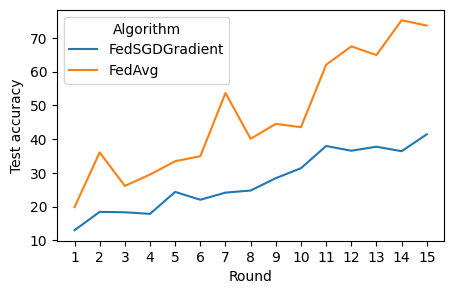

In [39]:
Ablation_Experiment(client_subsets = split(100, iid = False, seed = 10), nr_rounds = 15, display_flag = False)

TODO

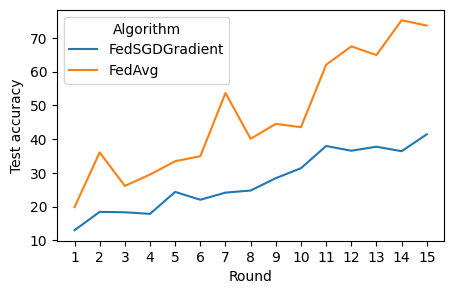

In [40]:
Ablation_Experiment(client_subsets = split(100, iid = False, seed = 10), nr_rounds = 15, display_flag = False)

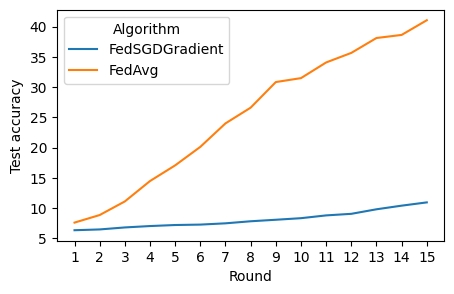

In [41]:
Ablation_Experiment(lr = 0.001, client_subsets = split(100, iid = False, seed = 10), nr_rounds = 15, client_fraction = 0.5, display_flag = False)

TODO